In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.table import Table
# Do with newly inspected table
vis_inp_table = '/Users/yingkangzhang/wps_workspace/wps_cloud/0-hi_z/inspected_catalog2.csv'
table_vi = pd.read_csv(vis_inp_table, encoding='gbk')
table_vi['Sample']


0           cand A
1           cand A
2             good
3       rejected B
4       rejected B
           ...    
2383        good B
2384          good
2385    rejected A
2386        good B
2387          good
Name: Sample, Length: 2388, dtype: object

In [2]:
def just_show_distancev2(survey = 'first',
                        df_table = table_vi,
                        show_uplim = 3,
                        bin_size = 0.1,
    ):
    n_bins = int(show_uplim / bin_size)  # Number of bins based on

    df_good = table_vi[(table_vi['Sample'].str.contains('good'))].reset_index(drop=True)
    # df_cand = table_vi[(table_vi['Sample'].str.contains('cand B')) | (table_vi['Sample'].str.contains('cand C'))].reset_index(drop=True)
    df_cand = table_vi[(table_vi['Sample'].str.contains('cand'))].reset_index(drop=True)
    df_reje = table_vi[(table_vi['Sample'].str.contains('rejected B')) | (table_vi['Sample'].str.contains('rejected C'))].reset_index(drop=True)

    data_1 = df_good['sep_'+survey]
    data_2 = df_cand['sep_'+survey]
    data_3 = df_reje['sep_'+survey]
    data_1 = data_1.dropna(); data_2 = data_2.dropna(); data_3 = data_3.dropna()
    print(f"The number of data points: {len(data_1)}")
    print(f"The number of data points cand: {len(data_2)}")
    print(f"The number of data points reje: {len(data_3)}")

    plt.figure(figsize=(9, 6))
    plt.hist([data_1,data_2,data_3], bins=n_bins, range=(0, show_uplim),
         stacked=True,
         linewidth=0.2,
         edgecolor='black',
         color=['steelblue', 'darkorange', 'lightcoral'],
         label=[f'Separation_{survey} (good)', f'Separation_{survey} (candidate)', f'Separation_{survey} (rejected)'])
    survey_name=survey.upper()
    plt.title(f'{survey_name}-SDSS', fontsize=20)
    plt.xlabel(f'Separation (arcsec)', fontsize=20)
    plt.ylabel('Number of Sources', fontsize=20)
    # using log scale for y-axis
    plt.xlim(0, show_uplim)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig(f"./figures/SEP_{survey_name}_SDSS.pdf", format='pdf', dpi=200)
    plt.show()

The number of data points: 94
The number of data points cand: 51
The number of data points reje: 225


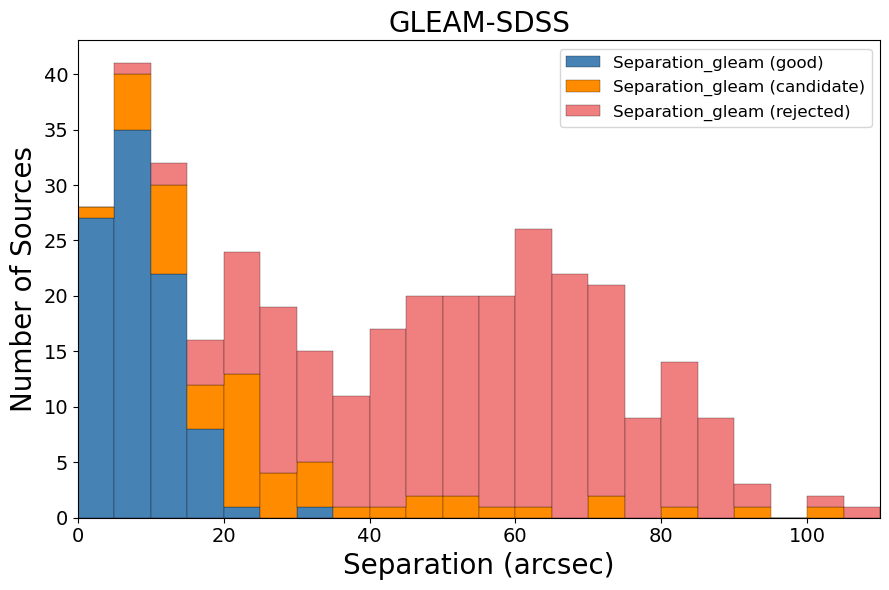

In [3]:
# just_show_distancev2(survey = 'first', show_uplim = 3, bin_size = 0.1)
# just_show_distancev2(survey = 'nvss', show_uplim = 25, bin_size = 0.5)
just_show_distancev2(survey = 'gleam', show_uplim = 110, bin_size = 5)
# just_show_distancev2(survey = 'racs', show_uplim = 14, bin_size = 0.5)

### figure new1: Likeli new

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.table import Table

#Define the function

def calc_r(ra_opt, dec_opt, ra_radio, dec_radio, sigma_ra_opt, sigma_dec_opt, sigma_ra_radio, sigma_dec_radio):
    """
    Calculate the normalized distance r between optical and radio sources.
    Parameters:
    ras and decs (float): Right Ascension and Declination of the source (both optical and radio) in degrees.
    sigmas (float): Uncertainties in Right Ascension and Declination for both optical and radio sources in arcseconds.
    Returns:
    float: Normalized distance r, based on arcsecond calculations.
    """

    sep_ra = (ra_opt - ra_radio) * np.cos(np.deg2rad(dec_opt))  # Convert to radians for cos
    sep_dec = dec_opt - dec_radio

    # before calculating r, change all variables to arcseconds
    sep_ra *= 3600  # Convert degrees to arcseconds
    sep_dec *= 3600  # Convert degrees to arcseconds
    r = np.sqrt(sep_ra**2/(sigma_ra_opt**2 + sigma_ra_radio**2) + sep_dec**2/(sigma_dec_opt**2 + sigma_dec_radio**2))

    return r

def rayleigh_pdf(x, sigma):
    # The Rayleigh probability density function (PDF)
    return (x / sigma**2) * np.exp(-x**2 / (2 * sigma**2))

In [8]:
# Get input table full, for parameters
final_table_path = 'final_matched_highz_catalogue.fits'
ref_table_patha = 'matched_radio_highz_catalogue.fits'
ref_table_pathb = 'ref_o1r1234_all_sources.fits'
with fits.open(final_table_path) as hdul:
    data = hdul[1].data
    table_fi = Table(data)
df_fi = table_fi.to_pandas()

with fits.open(ref_table_patha) as hdul:
    data = hdul[1].data
    table_fa = Table(data)
df_ref_a = table_fa.to_pandas()


with fits.open(ref_table_pathb) as hdul:
    data = hdul[1].data
    table_fb = Table(data)
df_ref_b = table_fb.to_pandas()

vis_inp_table = '/Users/yingkangzhang/wps_workspace/wps_cloud/0-hi_z/inspected_catalog2.csv'
df_vi = pd.read_csv(vis_inp_table, encoding='gbk')
df_vi

,sdss_name,sdss_ra,sdss_dec,sdss_z,sdss_source_z,sdss_zwarning,z_reliable_flag,FIRST,match_tier_first,Fpeak_first,...,sep_gleam,resolve_gleam,sdss_name.1,Sample,Note1,Note2,first_code,nvss_code,racs_code,gleam_code
0,000017.32-044502.3,0.072189,-4.750661,3.275,PIPE,0,2,J000017.3-044501,1.0,1.69,...,NaN,NaN,000017.32-044502.3,cand A,NaN,weak,U,ND,U,ND
1,000023.29+014501.8,0.097058,1.750519,3.097,PIPE,0,2,J000023.2+014501,1.0,2.36,...,NaN,NaN,000023.29+014501.8,cand A,NaN,NaN,U,U,SE,ND
2,000051.56+001202.5,0.214857,0.200716,3.865,VI,4,1,J000051.5+001202,1.0,2.74,...,NaN,NaN,000051.56+001202.5,good,NaN,NaN,U,SE,ND,ND
3,000055.68-100143.6,0.232028,-10.028793,3.264,VI,0,1,NaN,NaN,NaN,...,65.593,1.084,000055.68-100143.6,rejected B,cp dominate 4,NaN,ND,ND,ND,Ucp
4,000144.88-095630.8,0.437025,-9.941897,3.347,VI,0,1,NaN,NaN,NaN,...,20.920,0.925,000144.88-095630.8,rejected B,cp closer,NaN,ND,ND,ND,Ucp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2383,235744.14+190433.5,359.433942,19.075997,3.454,VI,0,1,NaN,NaN,NaN,...,NaN,NaN,235744.14+190433.5,good B,NaN,affected by cp,ND,Uaf,ND,ND
2384,235758.55+140201.8,359.493964,14.033842,4.332,VI,68,1,NaN,NaN,NaN,...,NaN,NaN,235758.55+140201.8,good,NaN,NaN,ND,U,U,ND
2385,235802.27-035639.2,359.509482,-3.944235,3.322,PIPE,64,3,NaN,NaN,NaN,...,60.429,0.966,235802.27-035639.2,rejected A,redshift unreliable,NaN,NaN,Ucp,Ucp,Ucp
2386,235842.93-062515.4,359.678907,-6.420946,3.216,VI,0,1,J235842.9-062515,1.0,2.35,...,NaN,NaN,235842.93-062515.4,good B,NaN,3 affected by cp,U,Uaf,U,ND


In [9]:


# select subset with good only

def filter_df(df1,df_full):
    df1=df1[(df1['Sample'].str.contains('good'))].reset_index(drop=True)
    df_full=df_full[(df_full['sdss_name'].isin(df1['sdss_name']))].reset_index(drop=True)
    return df1,df_full

df_good,df_full_good= filter_df(df_vi, df_ref_a)
df_full_good

,sdss_name,sdss_ra,sdss_dec,sdss_class,sdss_z,sdss_source_z,sdss_z_pipe,sdss_zwarning,sdss_z_vi,sdss_z_conf,...,e_amaj0_r4,e_bmin0_r4,e_PA0_r4,Separation_racs,GrpSize_before_racs,group_z_min_racs,group_z_max_racs,GroupID_racs,GroupSize_racs,match_tier_racs
0,102651.46+590628.0,156.714441,59.107796,QSO,3.407,VI,3.407636,0,3.407,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
1,100025.33+590459.6,150.105554,59.083246,QSO,3.502,VI,3.502315,0,3.502,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
2,102032.50+585849.2,155.135452,58.980348,QSO,3.421,VI,3.421338,0,3.421,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
3,111014.02+585744.1,167.558426,58.962254,QSO,3.102,VI,3.101355,0,3.102,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
4,155307.12+585013.5,238.279675,58.837088,QSO,3.709,VI,3.729830,4,3.709,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,221304.34+141535.7,333.268094,14.259933,QSO,3.559,VI,3.559496,0,3.559,3.0,...,2.21,1.90,44.840000,1.678409,1,NaN,NaN,-2147483648,1,1
1632,230857.19+234006.0,347.238317,23.668349,QSO,3.387,VI,3.346591,0,3.387,3.0,...,7.23,5.02,42.330002,4.354491,1,NaN,NaN,-2147483648,1,1
1633,230650.41+253331.1,346.710057,25.558644,QSO,3.135,VI,3.134712,0,3.135,3.0,...,5.10,3.20,30.469999,1.240525,1,NaN,NaN,-2147483648,1,1
1634,231032.87-013329.5,347.636986,-1.558213,QSO,3.048,VI,3.047578,0,3.048,3.0,...,6.88,4.73,47.029999,3.573411,1,NaN,NaN,-2147483648,1,1


In [10]:
def make_df_likeli(df, survey):
    ra_opt = df['sdss_ra']; dec_opt = df['sdss_dec']
    sigma_ra_opt = 0.1 ;sigma_dec_opt = 0.1
    if survey == 'first':
        ra_radio = df['RA_deg_r1']; dec_radio = df['DEC_deg_r1']
        sigma_ra_radio = 0.4; sigma_dec_radio = 0.4
    elif survey == 'nvss':
        ra_radio = df['RA_deg_r2']; dec_radio = df['DEC_deg_r2']
        sigma_ra_radio = df['e_RAJ2000_r2']; sigma_dec_radio = df['e_DEJ2000_r2']
    elif survey == 'gleam':
        ra_radio = df['RA_deg_r3']; dec_radio = df['DEC_deg_r3']
        sigma_ra_radio = df['e_RAJ2000_r3']; sigma_dec_radio = df['e_DEJ2000_r3']
    elif survey == 'racs': 
        ra_radio = df['RA_deg_r4']; dec_radio = df['DEC_deg_r4']
        sigma_ra_radio = df['e_RAJ2000_r4']; sigma_dec_radio = df['e_DEJ2000_r4']
    else:
        raise ValueError("Invalid survey type. Choose from 'first', 'nvss', 'gleam', or 'racs'.")
    likeli_col = f'likeli_{survey}'
    df[likeli_col] = calc_r(ra_opt, dec_opt, ra_radio, dec_radio, sigma_ra_opt, sigma_dec_opt, sigma_ra_radio, sigma_dec_radio)
    print(f"Calculated likelihood r for {survey} survey.")
    return df

df_good_likeli = make_df_likeli(df_full_good, 'first')
df_good_likeli = make_df_likeli(df_good_likeli, 'nvss')
df_good_likeli = make_df_likeli(df_good_likeli, 'gleam')
df_good_likeli = make_df_likeli(df_good_likeli, 'racs')
# before saving to csv, reduce the long floats to 8 digits in case excel mis understand them
df_good_likeli_out = df_good_likeli.copy()
df_good_likeli_out.replace([-32768,-2147483648], 'NA', inplace=True)
df_good_likeli_out = df_good_likeli_out.round(8)
df_good_likeli_out.to_csv('df_good_likeli_after.csv', index=False)

df_good_likeli.columns
df_good_likeli.shape

Calculated likelihood r for first survey.
Calculated likelihood r for nvss survey.
Calculated likelihood r for gleam survey.
Calculated likelihood r for racs survey.


(1636, 100)

In [14]:
from scipy.stats import rayleigh, kstest
from scipy.optimize import curve_fit

def smooth_weight(x, center=1.0, width=0.5):
    # 高斯核权重：中心center，宽度控制参数width
    return np.exp(-0.5 * ((x - center) / width)**2)

def custom_weight(x, center=1.0, low_bound=0.5, up_bound=1.5):
    if low_bound <= x <= up_bound:
        return 1.0
    else:
        return 1 / ((x - center) ** 2)

# first, r range(0,5), can set to 3, bins=30
# nvss, r range(0,200) , can set to 60, bins=60
# gleam, not sure
# racs, r range(0,100), can set to 40, bins=40

def make_likeli_plot(survey = 'first',
                     df_in = df_good_likeli,
                     data_uplim = 5,
                     show_uplim = 3,
                     bin_size = 0.1,
                     t1_only = False
    ):
    n_bins = int(data_uplim / bin_size)  # Number of bins based on

    df_block_t1  = df_in[df_in['match_tier_'+survey] == 1].reset_index(drop=True)
    df_block_t23  = df_in[df_in['match_tier_'+survey] >= 2].reset_index(drop=True)
    df_block_tot = df_in[df_in['match_tier_'+survey] >= 1].reset_index(drop=True)

    data= df_in['likeli_'+survey]
    # data_t23 = df_block_t23['likeli_'+survey]
    # data = df_block_tot['likeli_'+survey]
    data=data.dropna()
    #data_t23 = data_t23.dropna()
    print(f"The number of data points: {len(data)}")

    data_r = data[data < data_uplim]
    hist, bin_edges = np.histogram(data_r, bins=n_bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # print(hist)
    # print(bin_edges)
    # print(bin_centers)
    weights = np.array([smooth_weight(x) for x in bin_centers])

    popt, pcov = curve_fit(rayleigh_pdf, bin_centers, hist, sigma=1/weights, absolute_sigma=False) 
    sigma_fit = popt[0]
    print(f"拟合参数 sigma = {sigma_fit:.4f}")

    # Make the axis for plot
    plt.figure(figsize=(9, 6))
    if t1_only:
        print("Plotting only tier 1 sources.")
        plt.hist(data_r, bins=n_bins, range=(0, data_uplim),
                edgecolor='black',
                # density=True,  # Normalize the histogram
                color='steelblue',
                label='Likelihood r distribution')
    else:
        print("Plotting tier 1 and tier 2/3 sources.")
        # plt.hist([data_t1,data_t23], bins=n_bins, range=(0, data_uplim),
        plt.hist([data], bins=n_bins, range=(0, data_uplim),
                 stacked=True,
                 #   density=True,  # Normalize the histogram
                 edgecolor='black',
                 color=['steelblue'],
                 label=['r distribution (tier 1)'])
    print("The fitting will only use tier 1 sources.")
    x = np.linspace(0, data_uplim, 500)
    y_pdf = rayleigh_pdf(x, sigma_fit)
    y_number = y_pdf * len(data_r) * bin_size  # Convert PDF to number density
    # plt.plot(x, y_pdf, 'r-', lw=2)
    plt.plot(x, y_number, 'r--', lw=2, label='Rayleigh PDF fit')
    plt.xlim(0, show_uplim)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('Relative distance r', fontsize=20)
    plt.ylabel('Number of sources', fontsize=20)
    plt.legend(fontsize=14)
    
    plt.tight_layout()
    plt.savefig(f"{survey}_r_distribution.pdf", format='pdf', dpi=200)
    plt.show()

    scale = sigma_fit  # 替换为你的 scale 参数
    upper_bound = rayleigh.ppf(0.997, loc=0, scale=scale)
    print(f"99.7% upper bound = {upper_bound:.4f}")

    rayleigh_dist = rayleigh(scale=sigma_fit)  # 创建瑞利分布对象
    ks_stat, p_value = kstest(data_r, rayleigh_dist.cdf)
    print(f"KS检验统计量: {ks_stat:.4f}, p值: {p_value:.4f}")

The number of data points: 810
拟合参数 sigma = 1.7373
Plotting tier 1 and tier 2/3 sources.
The fitting will only use tier 1 sources.


/var/folders/71/gshyfsc16lv27mjb4j1d21000000gn/T/ipykernel_55460/1353145657.py:47: RuntimeWarning: divide by zero encountered in divide
  popt, pcov = curve_fit(rayleigh_pdf, bin_centers, hist, sigma=1/weights, absolute_sigma=False)
/var/folders/71/gshyfsc16lv27mjb4j1d21000000gn/T/ipykernel_55460/1353145657.py:47: RuntimeWarning: overflow encountered in divide
  popt, pcov = curve_fit(rayleigh_pdf, bin_centers, hist, sigma=1/weights, absolute_sigma=False)


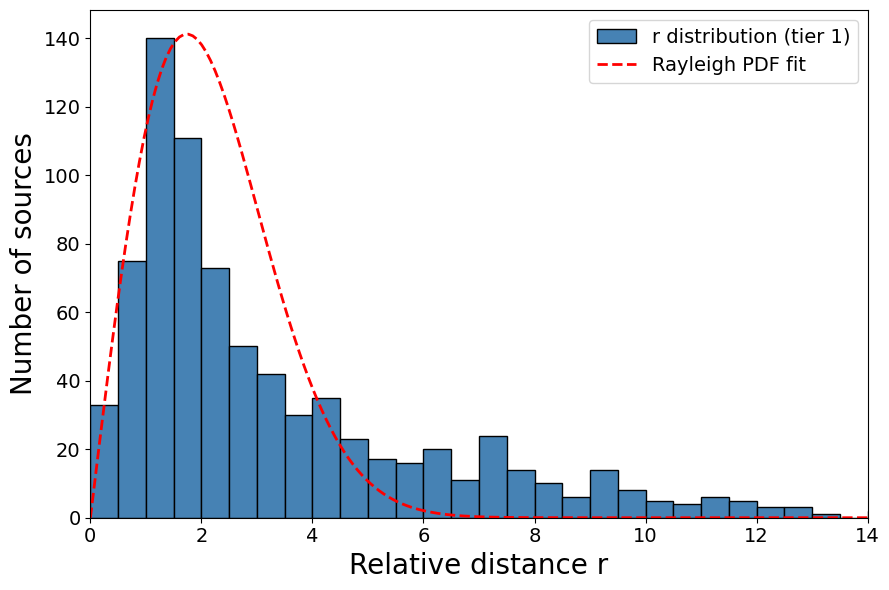

99.7% upper bound = 5.9219
KS检验统计量: 0.2460, p值: 0.0000


In [ ]:
# make_likeli_plot(survey = 'first', data_uplim = 3, show_uplim = 3, bin_size = 0.1, t1_only = False)
# make_likeli_plot(survey = 'nvss', data_uplim = 20, show_uplim = 30, bin_size = 1, t1_only = False)
# make_likeli_plot(survey = 'racs', data_uplim = 40, show_uplim = 14, bin_size = 0.5, t1_only = False)

### Figure 6 data analysis

In [71]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.table import Table
# prepare data

final_table_path = 'final_matched_highz_catalogue.fits'
ref_table_patha = 'matched_radio_highz_catalogue.fits'
ref_table_pathb = 'ref_o1r1234_all_sources.fits'
with fits.open(final_table_path) as hdul:
    data = hdul[1].data
    table_fi = Table(data)
df_fi = table_fi.to_pandas()

with fits.open(ref_table_patha) as hdul:
    data = hdul[1].data
    table_fa = Table(data)
df_ref_a = table_fa.to_pandas()

# select subset with z_reliable_flag == 1 and match_tier_first exist and =1
# df_z12 = df_fi[df_fi['z_reliable_flag'] <= 2].reset_index(drop=True)
# This block can be used to various analysis
def get_tier_flag(row,column_use):
    tiers = row[[column_use]]
    if any(t == 1 for t in tiers):
        return 'tier_1'
    elif any(t in [2, 3] for t in tiers):
        return 'tier23'
    else:
        return 'none'  # 可选
def filter_df(df1,df_full,z_flag_lim = 1):
    # df1.replace([-32768,-2147483648], 'NA', inplace=True)
    df1=df1[df1['z_reliable_flag'] <= z_flag_lim].reset_index(drop=True)
    df_full=df_full[(df_full['sdss_name'].isin(df1['sdss_name'])) | (df_full['match_tier_first'] >= -1) \
                     | (df_full['match_tier_nvss'] >= -1) | (df_full['match_tier_gleam'] >= -1) | (df_full['match_tier_racs'] >= -1)
                    ].reset_index(drop=True)
    return df1,df_full

df_good,df_full_good= filter_df(df_fi, df_ref_a, z_flag_lim=1)
df_ref_a


,sdss_name,sdss_ra,sdss_dec,sdss_class,sdss_z,sdss_source_z,sdss_z_pipe,sdss_zwarning,sdss_z_vi,sdss_z_conf,...,e_amaj0_r4,e_bmin0_r4,e_PA0_r4,Separation_racs,GrpSize_before_racs,group_z_min_racs,group_z_max_racs,GroupID_racs,GroupSize_racs,match_tier_racs
0,102651.46+590628.0,156.714441,59.107796,QSO,3.407000,VI,3.407636,0,3.407,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
1,100025.33+590459.6,150.105554,59.083246,QSO,3.502000,VI,3.502315,0,3.502,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
2,102032.50+585849.2,155.135452,58.980348,QSO,3.421000,VI,3.421338,0,3.421,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
3,111014.02+585744.1,167.558426,58.962254,QSO,3.102000,VI,3.101355,0,3.102,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
4,130204.52+585353.9,195.518857,58.898307,QSO,3.281111,PIPE,3.281111,0,-1.000,0.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9792,g232905.62-002711.2,352.273450,-0.453123,GALAXY,0.277300,phot,NaN,-32768,NaN,NaN,...,2.69,2.38,65.870003,2.599479,3,0.277300,3.542561,9168,2,-1
9793,231032.87-013329.5,347.636986,-1.558213,QSO,3.048000,VI,3.047578,0,3.048,3.0,...,6.88,4.73,47.029999,3.573411,1,NaN,NaN,-2147483648,1,1
9794,234109.47+213302.5,355.289460,21.550701,QSO,3.145000,VI,3.140290,0,3.145,3.0,...,3.20,2.61,45.639999,0.215557,1,NaN,NaN,-2147483648,1,1
9795,234830.29+011042.6,357.126242,1.178515,QSO,3.771000,VI,3.789262,0,3.771,3.0,...,0.51,0.28,2.020000,11.336677,2,1.695106,3.771000,9443,2,3


In [72]:
print(df_good.columns)
print(len(df_good))
print(df_full_good.columns)
df_full_good

Index(['sdss_name', 'sdss_ra', 'sdss_dec', 'sdss_z', 'sdss_source_z',
       'sdss_zwarning', 'z_reliable_flag', 'FIRST_r1', 'match_tier_first',
       'Fpeak_r1', 'Fint_r1', 'Rms_r1', 'NVSS_r2', 'match_tier_nvss',
       'S1.4_r2', 'e_S1.4_r2', 'GLEAM_r3', 'match_tier_gleam', 'Fpwide_r3',
       'e_Fpwide_r3', 'Fintwide_r3', 'e_Fintwide_r3', 'RACS-DR1_r4',
       'match_tier_racs', 'Fpk_r4', 'e_Fpk_r4', 'Ftot_r4', 'e_Ftot_r4'],
      dtype='object')
2132
Index(['sdss_name', 'sdss_ra', 'sdss_dec', 'sdss_class', 'sdss_z',
       'sdss_source_z', 'sdss_z_pipe', 'sdss_zwarning', 'sdss_z_vi',
       'sdss_z_conf', 'sdss_is_qso_qn', 'sdss_z_qn', 'FIRST_r1', 'RA_deg_r1',
       'DEC_deg_r1', 'Fpeak_r1', 'Fint_r1', 'Rms_r1', 'Maj_r1', 'Min_r1',
       'PA_r1', 'Separation_first', 'GrpSize_before_first',
       'group_z_min_first', 'group_z_max_first', 'GroupID_first',
       'GroupSize_first', 'match_tier_first', 'NVSS_r2', 'RA_deg_r2',
       'e_RAJ2000_r2', 'DEC_deg_r2', 'e_DEJ2000_r2', 'S1

,sdss_name,sdss_ra,sdss_dec,sdss_class,sdss_z,sdss_source_z,sdss_z_pipe,sdss_zwarning,sdss_z_vi,sdss_z_conf,...,e_amaj0_r4,e_bmin0_r4,e_PA0_r4,Separation_racs,GrpSize_before_racs,group_z_min_racs,group_z_max_racs,GroupID_racs,GroupSize_racs,match_tier_racs
0,102651.46+590628.0,156.714441,59.107796,QSO,3.407000,VI,3.407636,0,3.407,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
1,100025.33+590459.6,150.105554,59.083246,QSO,3.502000,VI,3.502315,0,3.502,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
2,102032.50+585849.2,155.135452,58.980348,QSO,3.421000,VI,3.421338,0,3.421,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
3,111014.02+585744.1,167.558426,58.962254,QSO,3.102000,VI,3.101355,0,3.102,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
4,130204.52+585353.9,195.518857,58.898307,QSO,3.281111,PIPE,3.281111,0,-1.000,0.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9792,g232905.62-002711.2,352.273450,-0.453123,GALAXY,0.277300,phot,NaN,-32768,NaN,NaN,...,2.69,2.38,65.870003,2.599479,3,0.277300,3.542561,9168,2,-1
9793,231032.87-013329.5,347.636986,-1.558213,QSO,3.048000,VI,3.047578,0,3.048,3.0,...,6.88,4.73,47.029999,3.573411,1,NaN,NaN,-2147483648,1,1
9794,234109.47+213302.5,355.289460,21.550701,QSO,3.145000,VI,3.140290,0,3.145,3.0,...,3.20,2.61,45.639999,0.215557,1,NaN,NaN,-2147483648,1,1
9795,234830.29+011042.6,357.126242,1.178515,QSO,3.771000,VI,3.789262,0,3.771,3.0,...,0.51,0.28,2.020000,11.336677,2,1.695106,3.771000,9443,2,3


In [73]:
def flux_vs_z(axs=ax1,
              df_input = df_good,
              survey = 'first',
              data_col = 'Fint_r1',
              error_col = 'Rms_r1',
              a_fmt = None,
              a_color = None
    ):
    # df_input['match_tier_'+survey].fillna(0, inplace=True)
    df_block_t1  = df_input[df_input['match_tier_'+survey] == 1].reset_index(drop=True)
    df_block_t23  = df_input[df_input['match_tier_'+survey] >= 2].reset_index(drop=True)
    df_block_tot = df_input[df_input['match_tier_'+survey] >= 1].reset_index(drop=True)

    def get_data(df,datacol,errorcol):
        data = df[datacol].dropna()
        error = df[errorcol].dropna()
        data=data.values 
        error=error.values
        if survey=='gleam':
            data= data * 1000
            error= error * 1000
        if len(data) != len(error):
            raise ValueError("Data and error arrays must have the same length.")
        return data, error
    if a_fmt is None:
        a_fmt = 'o'  # 默认使用圆点
    data_t1, error_t1 = get_data(df_block_t1, data_col, error_col)
    data_t23, error_t23 = get_data(df_block_t23, data_col, error_col)
    data, error = get_data(df_block_tot, data_col, error_col)
    print(f"The number of data points: {len(data)}")

    axs.errorbar(df_block_tot['sdss_z'], data, yerr=error, fmt=a_fmt, mec=a_color, label=survey, ms=5,mfc=None)
    survey_name=survey.upper()
    return survey


NameError: name 'ax1' is not defined

The number of data points: 1494
The number of data points: 1489
The number of data points: 335
The number of data points: 888


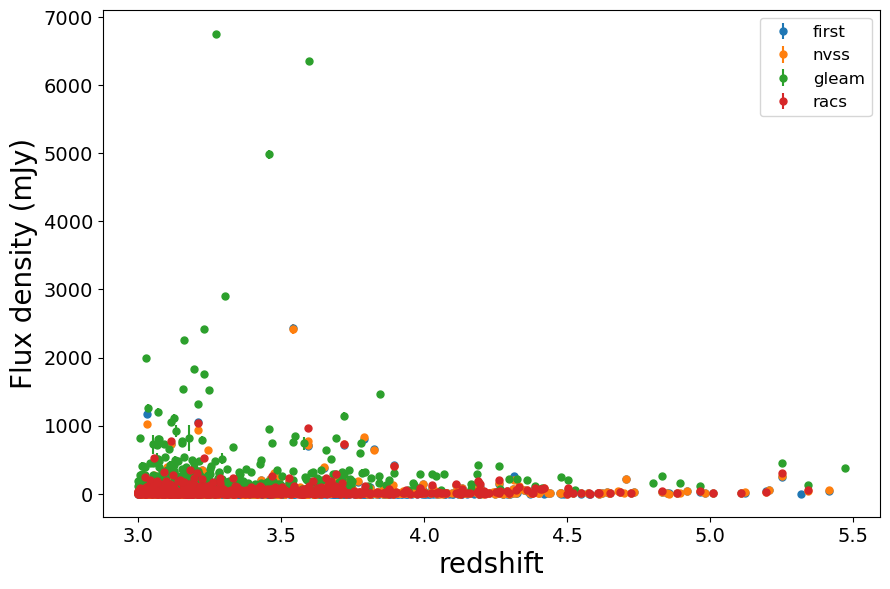

In [ ]:
ax1 = plt.figure(figsize=(9, 6))
ax1 = plt.subplot(111)

survey_name = flux_vs_z(axs=ax1,df_input=df_good ,survey = 'first', data_col = 'Fint_r1', error_col = 'Rms_r1')
survey_name = flux_vs_z(axs=ax1,df_input=df_good ,survey = 'nvss', data_col = 'S1.4_r2', error_col = 'e_S1.4_r2')
survey_name = flux_vs_z(axs=ax1,df_input=df_good ,survey = 'gleam', data_col = 'Fintwide_r3', error_col = 'e_Fintwide_r3')
survey_name = flux_vs_z(axs=ax1,df_input=df_good ,survey = 'racs', data_col = 'Ftot_r4', error_col = 'e_Ftot_r4')
ax1.set_xlabel(f'redshift', fontsize=20)
ax1.set_ylabel('Flux density (mJy)', fontsize=20)
# using log scale for y-axis
# ax1.set_ylim(0, 1000)
# ax1.set_yscale('log')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend(fontsize=12)
plt.tight_layout()
# plt.savefig(f"{survey_name}_SDSS_flux.pdf", format='pdf', dpi=200)
plt.show()

### Table: make the final tables for paper

In [75]:
from pathlib import Path
import pandas as pd
import os
os.chdir('/Users/yingkangzhang/wps_workspace/wps_cloud/hi_z')
ref_after = Path("/Users/yingkangzhang/wps_workspace/wps_cloud/hi_z/inspected_catalog2.csv")
table_after = pd.read_csv(ref_after,encoding='gbk')
table_after.columns

Index(['sdss_name', 'sdss_ra', 'sdss_dec', 'sdss_z', 'sdss_source_z',
       'sdss_zwarning', 'z_reliable_flag', 'FIRST', 'match_tier_first',
       'Fpeak_first', 'Fint_first', 'Rms_first', 'NVSS', 'match_tier_nvss',
       'S1.4_nvss', 'e_S1.4_nvss', 'GLEAM', 'match_tier_gleam', 'Fpwide_gleam',
       'e_Fpwide_gleam', 'Fintwide_gleam', 'e_Fintwide_gleam', 'RACS-DR1',
       'match_tier_racs', 'Fpk_racs', 'e_Fpk_racs', 'Ftot_racs', 'e_Ftot_racs',
       'match_tier_flag', 'match_tier_mark', 'sep_first', 'sep_nvss',
       'sep_racs', 'sep_gleam', 'resolve_gleam', 'sdss_name.1', 'Sample',
       'Note1', 'Note2', 'first_code', 'nvss_code', 'racs_code', 'gleam_code'],
      dtype='object')

In [81]:
# define columns for table1: classification table
columns_t1_mapping={'sdss_name':'sdss_name','sdss_ra':'sdss_ra','sdss_dec':'sdss_dec','Sample':'category','sdss_z':'sdss_z',
            'sdss_source_z':'sdss_source_z','sdss_zwarning':'sdss_zwarning','z_reliable_flag':'z_reliable_flag',
            'FIRST':'FIRST','NVSS':'NVSS','RACS-DR1':'RACS','GLEAM':'GLEAM','match_tier_mark':'match_tier_code',
            'sep_first':'SEP_FIRST','sep_nvss':'SEP_NVSS','sep_racs':'SEP_RACS','sep_gleam':'SEP_GLEAM',
            'first_code':'VI_code_FIRST','nvss_code':'VI_code_NVSS','racs_code':'VI_code_RACS','gleam_code':'VI_code_GLEAM',
            'Note1':'comment_1','Note2':'comment_2'}

df_t1 = table_after[columns_t1_mapping.keys()].rename(columns=columns_t1_mapping)
df_t1.replace([-32768,-2147483648], 'NA', inplace=True)
df_t1['match_tier_code'] = df_t1.apply(lambda row: f"{int(row['match_tier_code']):04d}" if pd.notna(row['match_tier_code']) else "0000", axis=1)
df_t1['sdss_ra'] = df_t1['sdss_ra'].round(8)
df_t1['sdss_dec'] = df_t1['sdss_dec'].round(8)
df_t1.to_csv('final_table1_category.csv', index=False)
# define columns for table2: parameter table
columns_t2=['sdss_name','sdss_ra','sdss_dec','Sample','sdss_z',
            'FIRST', 'Fpeak_first', 'Fint_first', 'Rms_first',
            'NVSS','S1.4_nvss','e_S1.4_nvss',
            'RACS-DR1','Fpk_racs','e_Fpk_racs','Ftot_racs','e_Ftot_racs',
            'GLEAM','Fpwide_gleam','e_Fpwide_gleam','Fintwide_gleam','e_Fintwide_gleam'
            ]

df_t2 = table_after[columns_t2]
df_t2.rename(columns={'Sample':'category'}, inplace=True)
df_t2['sdss_ra'] = df_t2['sdss_ra'].round(8)
df_t2['sdss_dec'] = df_t2['sdss_dec'].round(8)
df_t2.replace([-32768,-2147483648], 'NA', inplace=True)
df_t2.to_csv('final_table2_parameters.csv', index=False)


/var/folders/71/gshyfsc16lv27mjb4j1d21000000gn/T/ipykernel_23306/3912438776.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t2.rename(columns={'Sample':'category'}, inplace=True)
/var/folders/71/gshyfsc16lv27mjb4j1d21000000gn/T/ipykernel_23306/3912438776.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t2['sdss_ra'] = df_t2['sdss_ra'].round(8)
/var/folders/71/gshyfsc16lv27mjb4j1d21000000gn/T/ipykernel_23306/3912438776.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

### Test for the galaxy catalg

In [ ]:
import pandas as pd
from astropy.io import fits
import numpy as np
from astropy.table import Table

# tables to be concatenated
sdss_galaxy = "../catalogues/dr16_galaxy_all.fits"
dr16q_short = "tmp_sdss.fits"

with fits.open(sdss_galaxy) as hdul:
    data = hdul[1].data 
    table_g = Table(data)  
df_g = table_g.to_pandas()  
with fits.open(dr16q_short) as hdul:
    data = hdul[1].data  
    table_q = Table(data) 
df_q = table_q.to_pandas()  


In [ ]:
combined_df = pd.concat([df_q, df_g], ignore_index=True, sort=False)
combined_df

In [ ]:

combined_df_sorted = combined_df.sort_values(by='SDSS_NAME', ascending=True)
combined_df_sorted.reset_index(drop=True, inplace=True)

table_combined = Table.from_pandas(combined_df_sorted)
table_combined.write('tmp_sdss16_sorted.fits', format='fits', overwrite=True)

print(f"Saved combined table with {len(combined_df_sorted)} rows to 'combined_sdss_sorted.fits'")
print("First few rows after sorting:")
print(combined_df_sorted[['SDSS_NAME', 'RA', 'DEC', 'Z']].head())